# Notebook for model architecture

## Imports

In [3]:
#imports for the plot
import matplotlib.pyplot as plt

#imports for torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# imports for the data
import kagglehub
import pandas as pd
import os
import numpy as np
import math
import yfinance as yf

## Load the data

In [18]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
df = yf.download("NVDA", start="1999-01-22", end="2025-03-15", auto_adjust=False)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
1999-01-22,0.037612,0.041016,0.048828,0.038802,0.043750,2714688000
1999-01-25,0.041552,0.045313,0.045833,0.041016,0.044271,510480000
1999-01-26,0.038328,0.041797,0.046745,0.041146,0.045833,343200000
1999-01-27,0.038209,0.041667,0.042969,0.039583,0.041927,244368000
1999-01-28,0.038089,0.041536,0.041927,0.041276,0.041667,227520000


In [12]:
column_names = df.columns.get_level_values(0).tolist()
df.columns = column_names
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1999-01-22,0.037612,0.041016,0.048828,0.038802,0.043750,2714688000
1999-01-25,0.041552,0.045313,0.045833,0.041016,0.044271,510480000
1999-01-26,0.038328,0.041797,0.046745,0.041146,0.045833,343200000
1999-01-27,0.038209,0.041667,0.042969,0.039583,0.041927,244368000
1999-01-28,0.038089,0.041536,0.041927,0.041276,0.041667,227520000


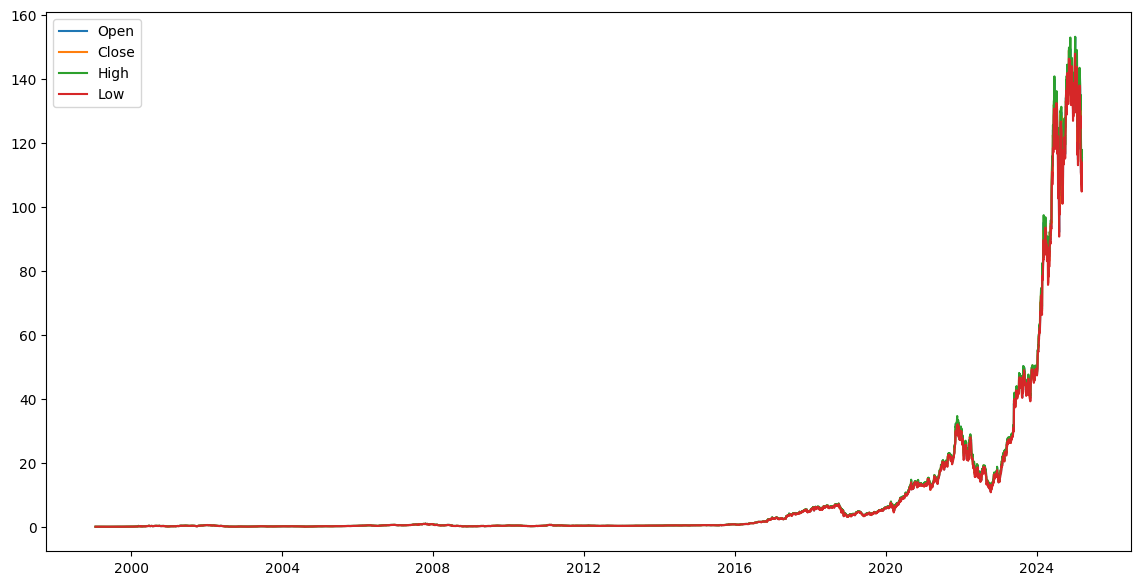

In [13]:
#create a column for the opening price of the next day
df['Next_Open'] = df['Open'].shift(-1)
df = df.dropna()

#plot the data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Open'], label='Open')
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['High'], label='High')
plt.plot(df.index, df['Low'], label='Low')
plt.legend()

In [14]:
#statistical analysis of the data
df.describe()

,Adj Close,Close,High,Low,Open,Volume,Next_Open
count,6576.000000,6576.000000,6576.000000,6576.000000,6576.000000,6.576000e+03,6576.000000
mean,9.078872,9.106545,9.278503,8.922732,9.111640,5.983126e+08,9.129670
std,24.606490,24.606150,25.087566,24.105409,24.646650,4.304237e+08,24.683356
min,0.031283,0.034115,0.035547,0.033333,0.034896,1.968000e+07,0.034896
25%,0.258380,0.281766,0.289187,0.273625,0.281062,3.377800e+08,0.281208
50%,0.437858,0.467250,0.474083,0.460125,0.467500,4.994920e+08,0.467500
75%,4.672070,4.707813,4.776250,4.632250,4.726437,7.302070e+08,4.732750
max,149.416245,149.429993,153.130005,147.820007,153.029999,9.230856e+09,153.029999


In [15]:
#create dataset/dataloader objects
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        # Select columns corresponding to the different inputs and outputs from the dataframe we just created.
        # And convert to PyTorch tensors
        x1 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Adj Close'].values, dtype=torch.float32)
        x2 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Close'].values, dtype=torch.float32)
        x3 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['High'].values, dtype=torch.float32)
        x4 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Low'].values, dtype=torch.float32)
        x5 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Open'].values, dtype=torch.float32)
        x6 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Volume'].values, dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx + self.window_size]['Next_Open'], dtype=torch.float32)
        # Assemble all input features in a single inputs tensor with 2 columns and rows for each sample in the dataset.
        inputs = torch.stack([x1, x2, x3, x4, x5, x6], dim = 0)
        return inputs, y
    

#train-test split
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train_data = df.iloc[:train_size, :]
test_data = df.iloc[train_size:, :]
print(train_data.shape, test_data.shape)

train_dataset = StockDataset(train_data, window_size=10)
test_dataset = StockDataset(test_data, window_size=10)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



(4932, 7) (1644, 7)


In [ ]:
#model
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size #numbers of features in input
        self.hidden_size = hidden_size #number of features in hidden state
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM cell
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = self.num_layers, 
                                  batch_first = True)
        self.dropout = torch.nn.Dropout(0.2)

        
        # Linear layer for final prediction
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_size, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.randn(self.num_layers, input_size, self.hidden_size).to(device)
            c0 = torch.randn(self.num_layers, input_size, self.hidden_size).to(device)
        
        out, (hn, cn) = self.lstm(input_size, (h0, c0))
        out = self.linear(out[:, -1, :])
        return out, hn, cn

In [19]:
# Define the model parameters
input_size = 10
hidden_size = 12
num_layers = 2
output_size = 1

#Create the model
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

LSTM(
  (lstm): LSTM(10, 12, num_layers=2, batch_first=True)
  (linear): Linear(in_features=12, out_features=1, bias=True)
)


In [20]:
#display sized of inputs and targets in train_loader
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape) 
    #inputs is a tensor of size [batch_size, 6, 10] and targets is a tensor of size [batch_size]
    break

torch.Size([64, 6, 10]) torch.Size([64])


In [21]:
#training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        model.train()
        optimizer.zero_grad()
        
        h0 = torch.randn(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        c0 = torch.randn(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        
        outputs, h0, c0 = model(inputs, h0, c0)
        
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        
        h0 = h0.detach()
        c0 = c0.detach()

    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch: 10/100, Loss: 0.007258178200572729
Epoch: 20/100, Loss: 0.0037383537273854017
Epoch: 30/100, Loss: 0.007715380750596523
Epoch: 40/100, Loss: 0.0013051514979451895
Epoch: 50/100, Loss: 0.004606332164257765
Epoch: 60/100, Loss: 0.002760557224974036
Epoch: 70/100, Loss: 0.0019321285653859377
Epoch: 80/100, Loss: 0.0006247422425076365
Epoch: 90/100, Loss: 0.0015438655391335487
Epoch: 100/100, Loss: 0.004492908250540495


Test loss: 0.12790453433990479


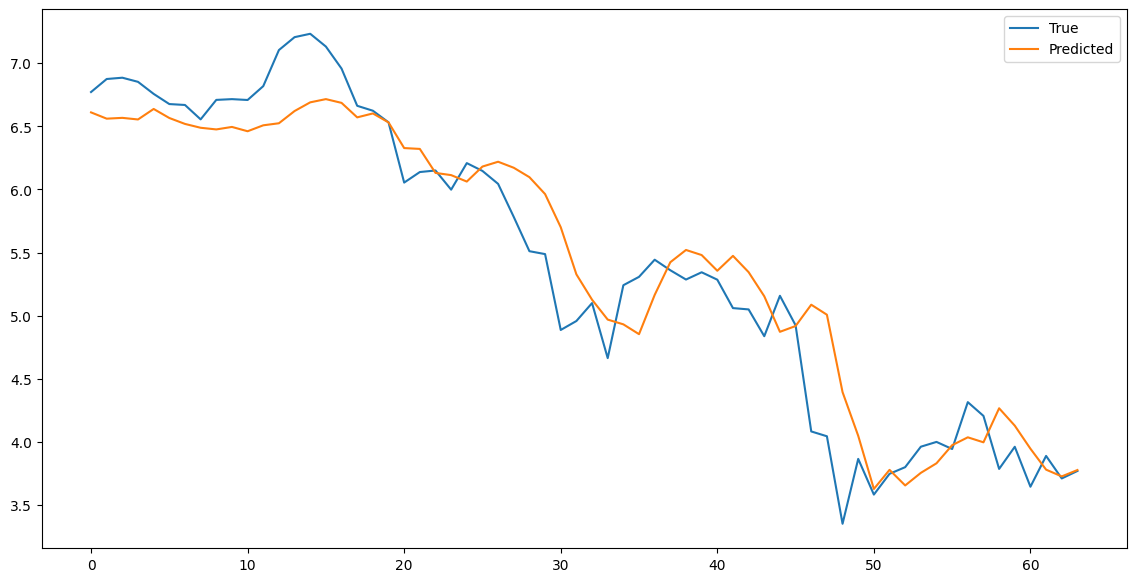

In [22]:
#testing
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        h0 = torch.randn(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        c0 = torch.randn(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        
        outputs, h0, c0 = model(inputs, h0, c0)
        
        loss = criterion(outputs.squeeze(), targets)
        print(f'Test loss: {loss.item()}')

        outputs = outputs.squeeze().cpu().numpy()
        targets = targets.cpu().numpy()
        break

#plot the results
plt.figure(figsize=(14, 7))
plt.plot(targets, label='True')
plt.plot(outputs, label='Predicted')
plt.legend()
plt.show()